# Ideal Parameter Analysis ($\delta=1.75$, $\tau=1.25$, $\alpha=2$) ($\delta$ low)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 1.75
expected_tau = 1.25
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

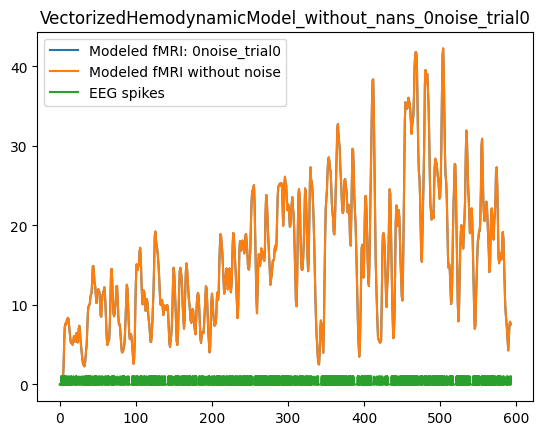

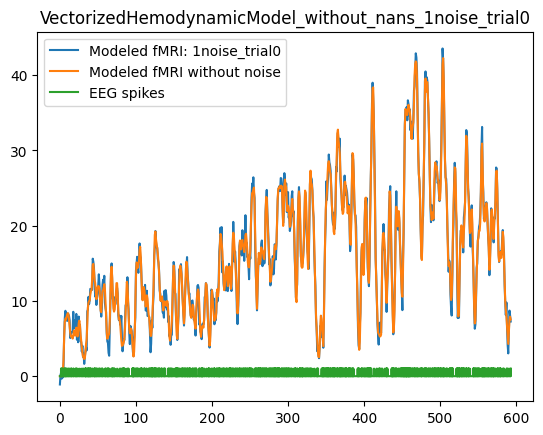

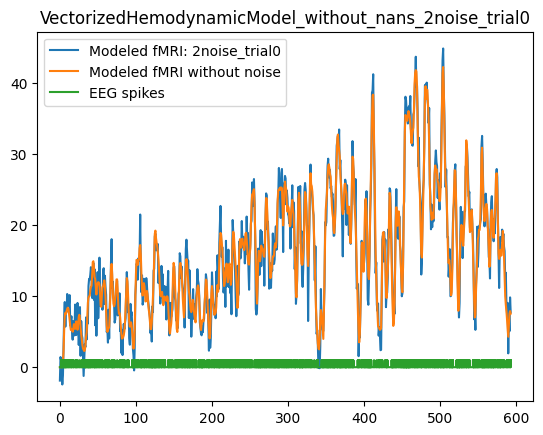

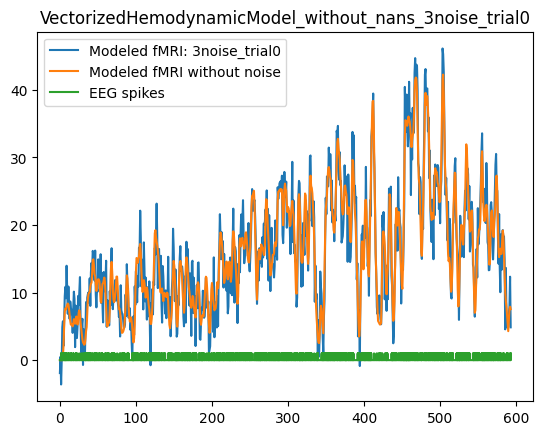

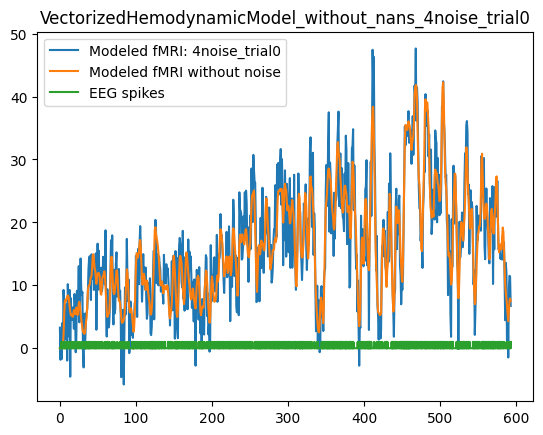

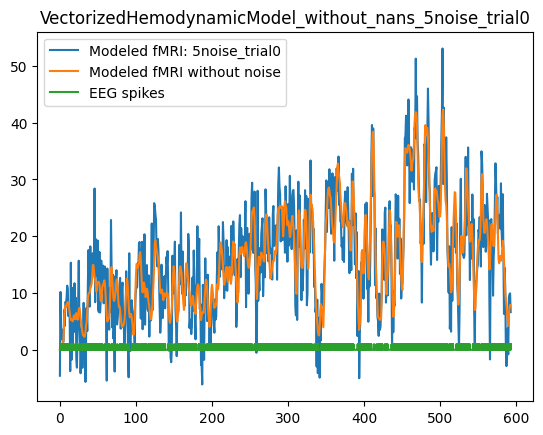

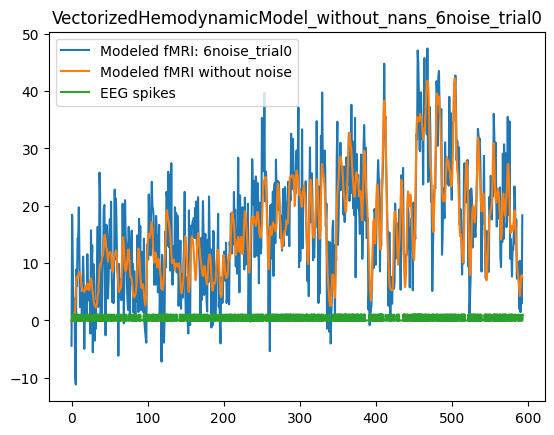

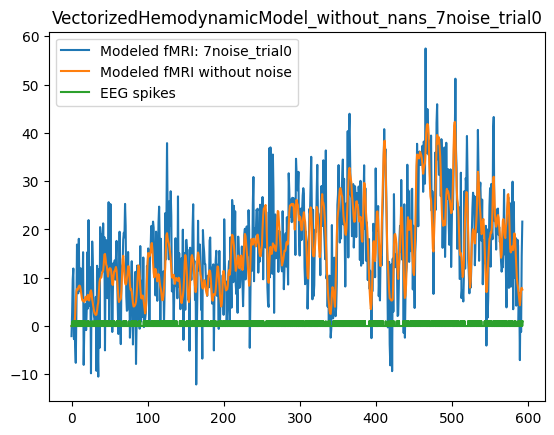

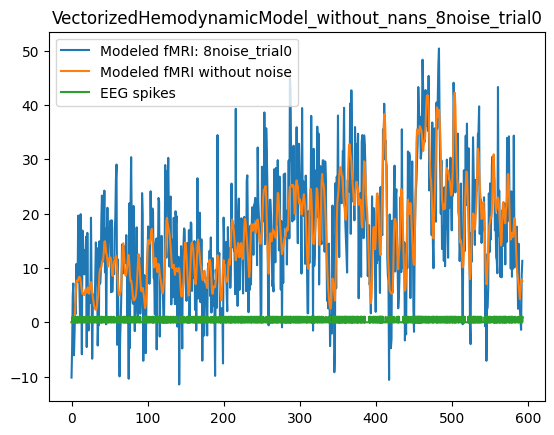

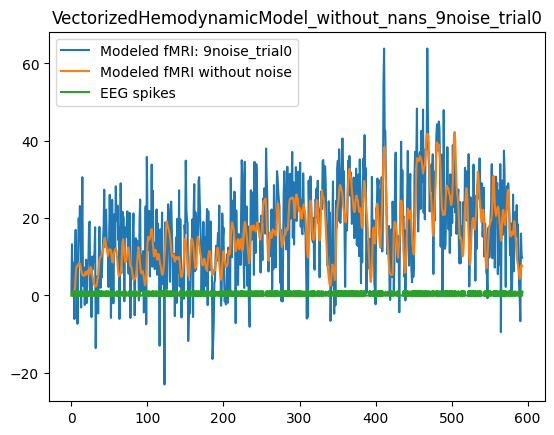

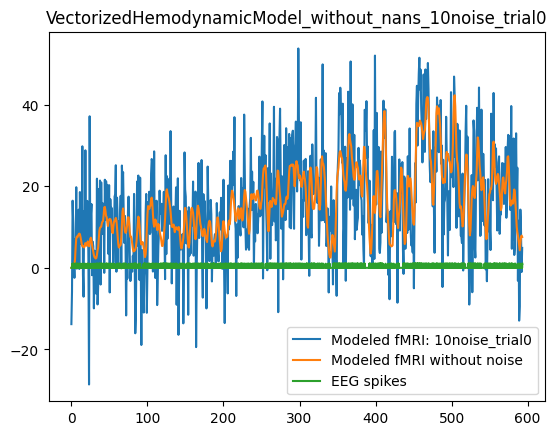

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 1.75, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=1.75, tau=1.25, alpha=2


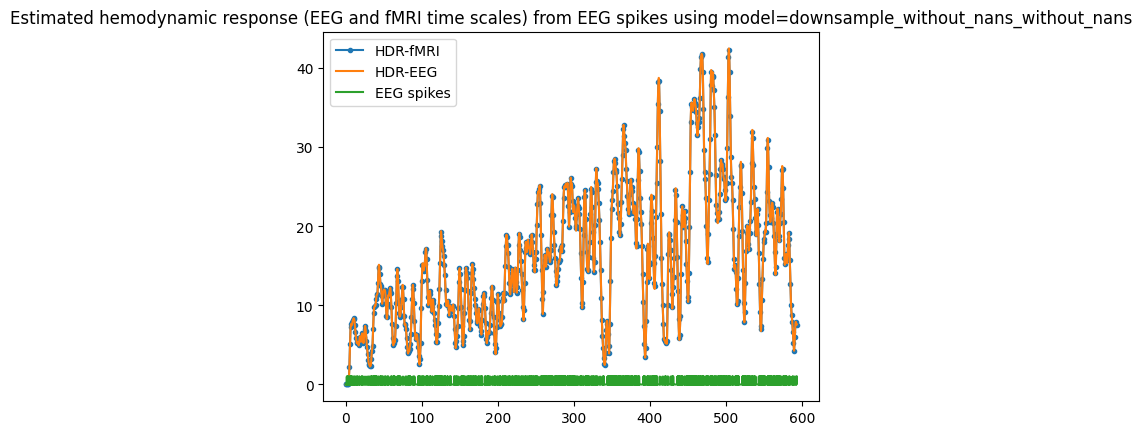

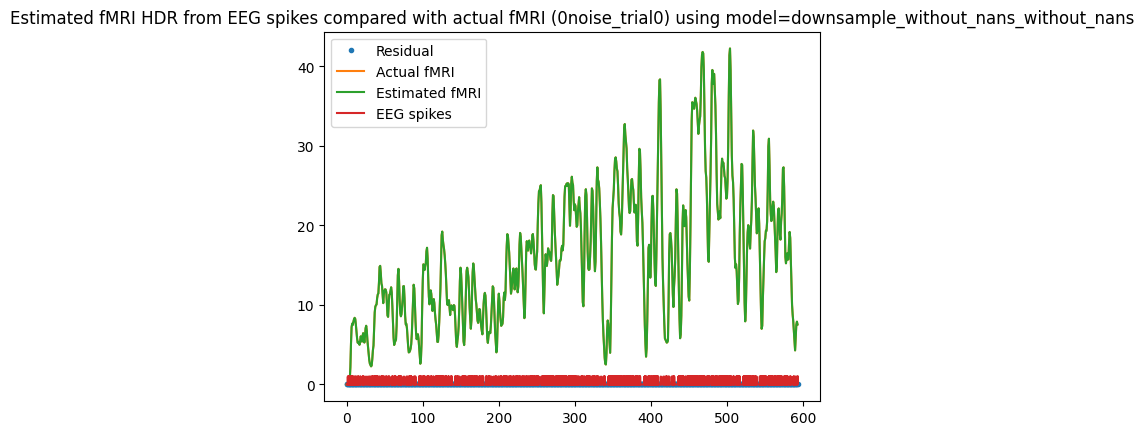

Residual Variance is 0.000000


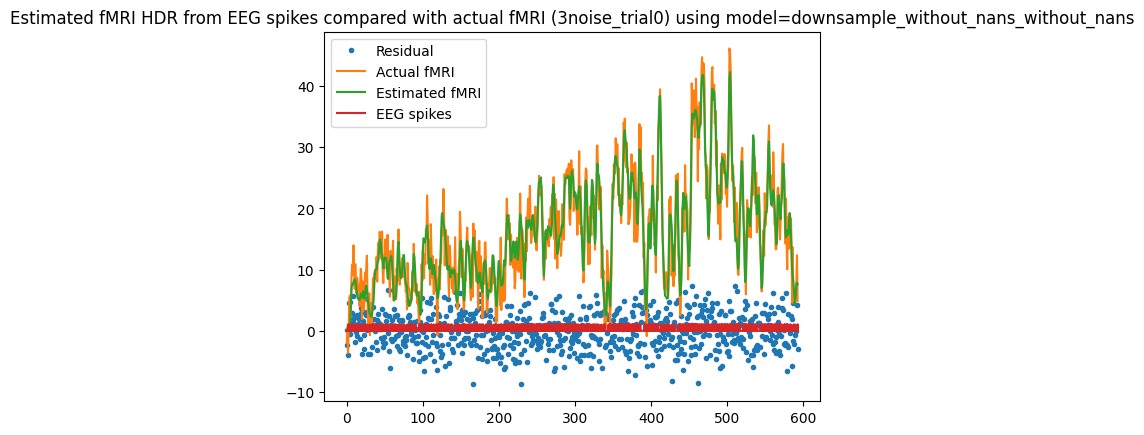

Residual Variance is 8.800366


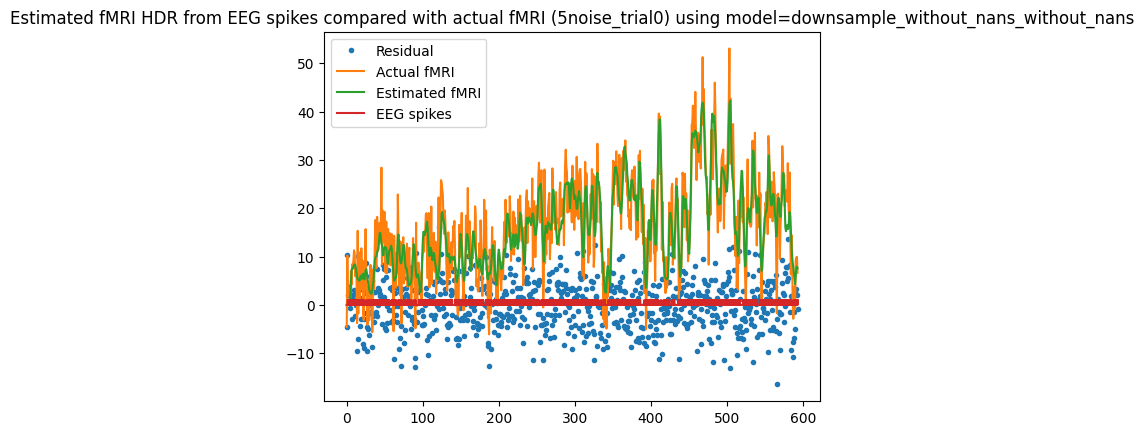

Residual Variance is 25.971774


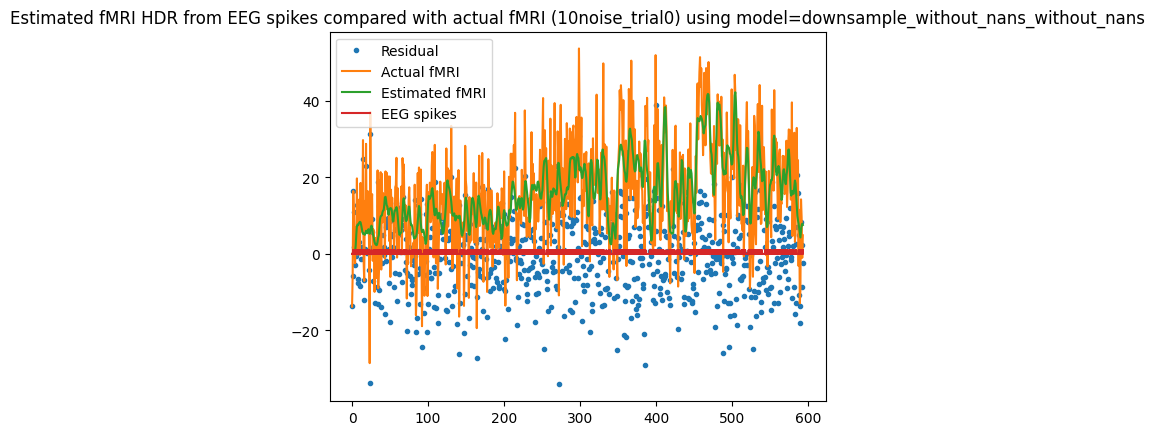

Residual Variance is 103.850635


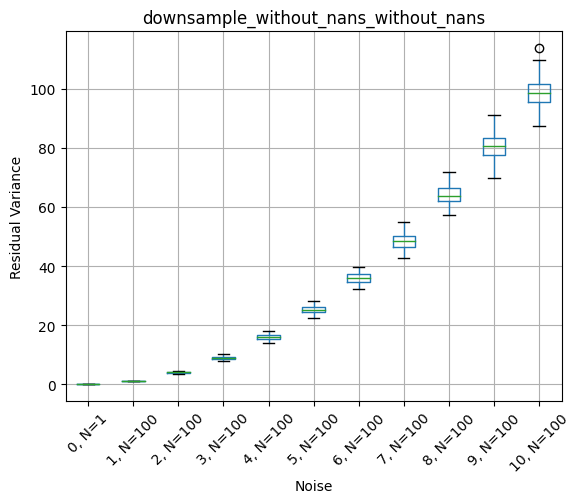

Scoring downsample_without_nans_with_nans delta=1.75, tau=1.25, alpha=2


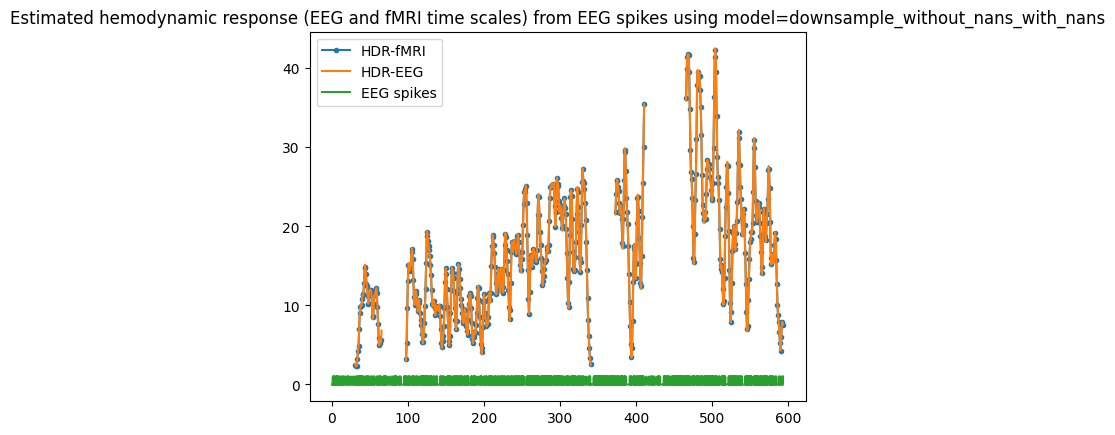

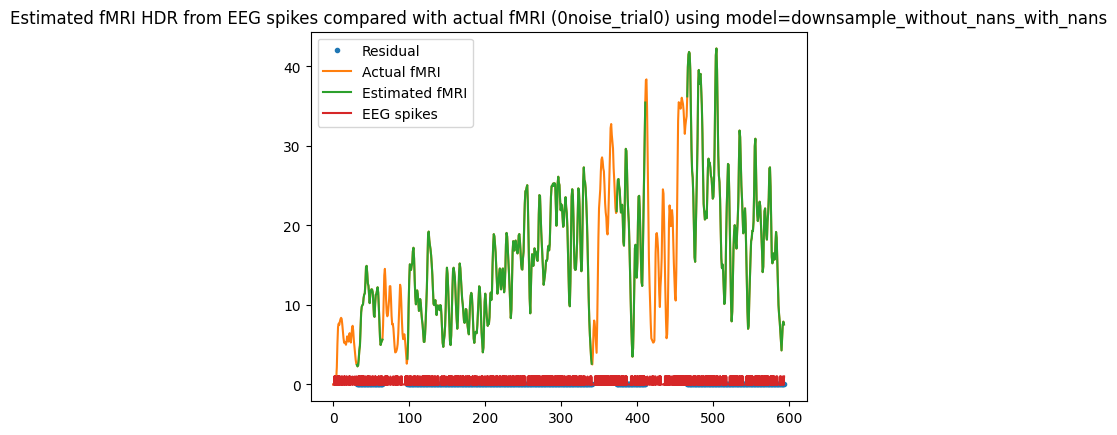

Residual Variance is 0.000000


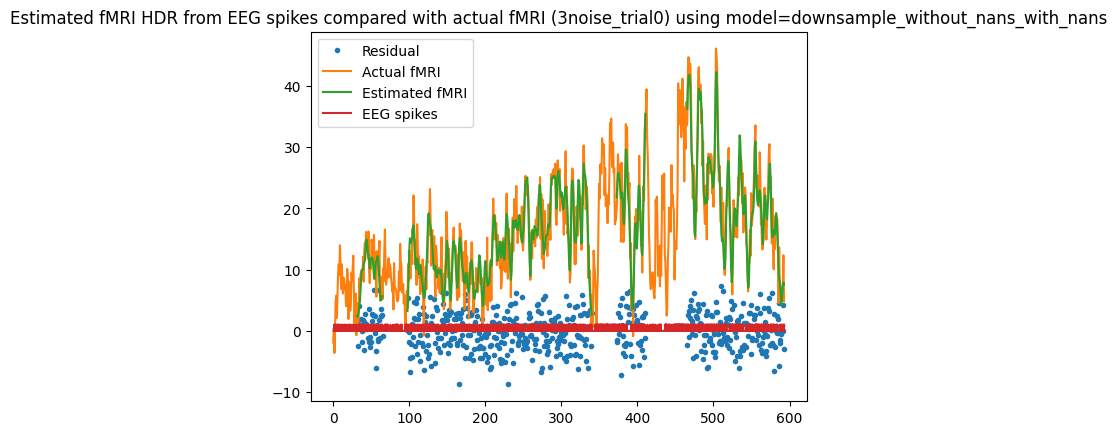

Residual Variance is 8.987491


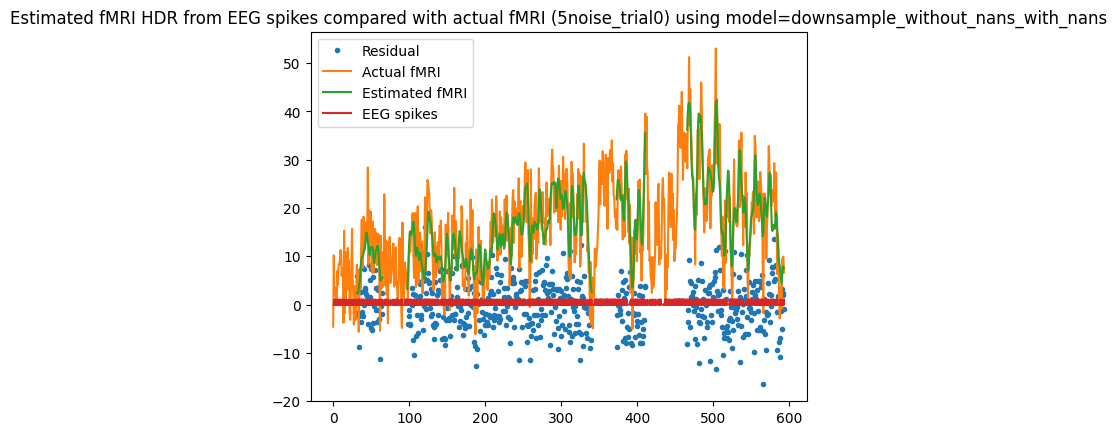

Residual Variance is 26.828070


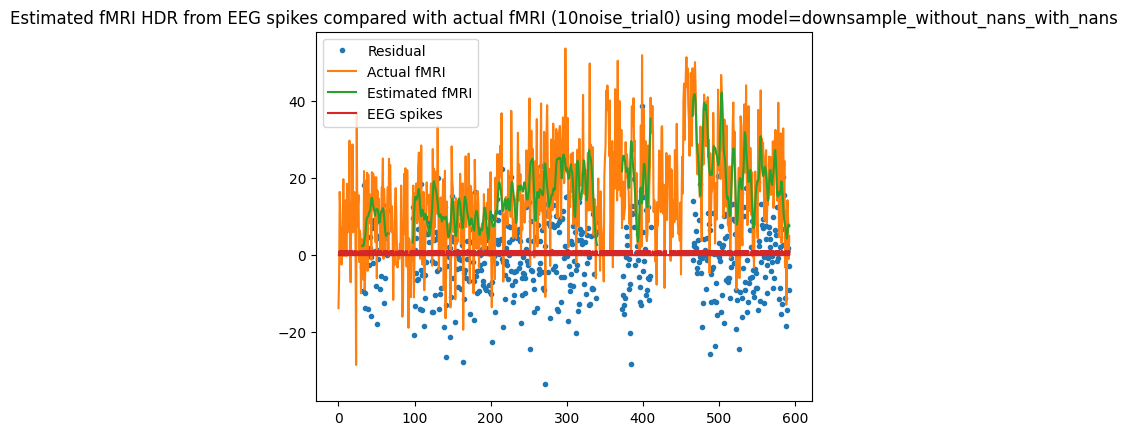

Residual Variance is 101.479419


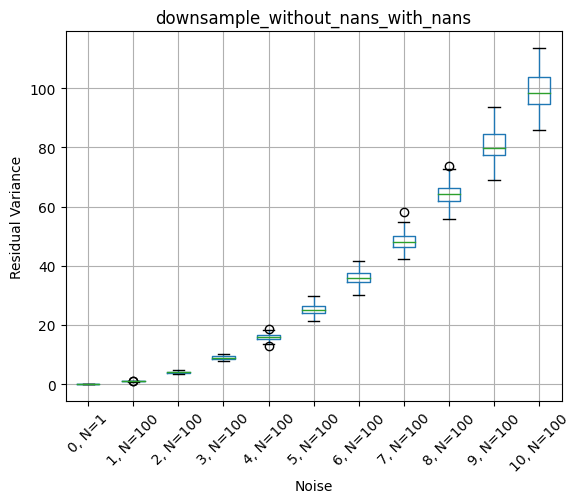

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans  33.389177853593964   
1         downsample_without_nans_with_nans   30.84825544894833   
2      downsample_without_nans_without_nans  32.405876525352134   
3         downsample_without_nans_with_nans  29.970450709152853   
4      downsample_without_nans_without_nans   31.42426103629359   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  19.668481257740286   
18938  downsample_without_nans_without_nans  22.103853992006027   
18939     downsample_without_nans_with_nans  20.311841961205324   
18940  downsample_without_nans_without_nans  22.834720040328314   
18941     downsample_without_nans_with_nans  20.942714987473178   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       34.16779700301174  39.533964384651476   42.32157215098858   
1      31.866488091972464   37.20401177382758   40.94789117200676   
2      33.179200763574705   38.52622075586154   41.35384540679563   
3      30.966853323524663  36.318091011658026  40.080863963962415   
4       32.19276491057013   37.51865057289877   40.38648284987748   
...                   ...                 ...                 ...   
18937  21.214799229101367  24.208702695986798   26.76798328283143   
18938  23.266983072796354  26.727018279220953   29.60307255866947   
18939  21.869509697405267   24.86800013101104  27.382730550477522   
18940  24.000501731935273  27.480541998294786  30.300475231355527   
18941  22.511798402929188  25.514010424983336   27.98700684802257   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       50.24955518501619   56.43385759559797  ...  34.277382177760316   
1      45.634189225573806   56.93191502386721  ...  31.570221495460448   
2      49.256626382878615   55.44018144314414  ...   33.28835586744444   
3       44.78486349178587  56.031711268268005  ...  30.689572743862612   
4      48.265268313605006  54.451981897566526  ...   32.30126112782461   
...                   ...                 ...  ...                 ...   
18937   36.44245882821386  48.093089295225994  ...  20.864373172386024   
18938  39.164419352522785   49.98032616028952  ...  23.438399375099973   
18939   37.07677770018838   48.76796131778266  ...  21.504758758696898   
18940   39.92665885090132   50.70943018640699  ...  24.170770250840707   
18941   37.69864778003876   49.42986746076017  ...   22.13262774233159   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       37.22139832080685  43.150113512655466   49.19873224115429   
1       34.88322078197683   40.16522988908315   46.05674851482386   
2       36.21671841766387   42.14090740470436  48.258468011241504   
3       33.98055421334719   39.27985543616759   45.24123544616919   
4       35.21497611026954   41.13294627852773   47.31795962452477   
...                   ...                 ...                 ...   
18937   24.29917440567591  28.326115821001213   34.16182812798209   
18938  26.187892402250764   32.29723846592366   37.04484005410385   
18939  24.938407285130527  28.986721636441153  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.5929991208145947e-28; at
      delta   tau  alpha
7160   1.75  1.25    2.0


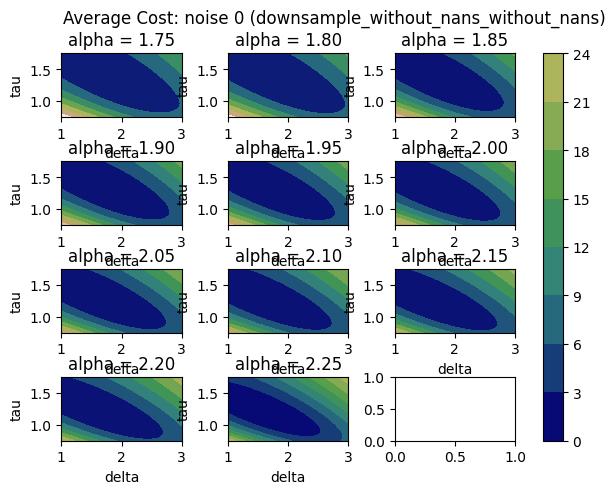

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              33.389178             
2                                              32.405877             
4                                              31.424261             
6                                              30.445333             
8                                              29.470092             
...                                                  ...             
18932                                          19.848178             
18934                                          20.609841             
18936                                          21.361995             
18938                                          22.103854             
18940                                          22.834720             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1.75, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   1.75  1.25    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1.75, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.303537e-03   1.70  1.20   2.15
1      0         0  2.592999e-28   1.75  1.25   2.00
2      0         0  5.313808e-03   1.80  1.30   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 3.7130063718106687e-28; at
      delta   tau  alpha
7161   1.75  1.25    2.0


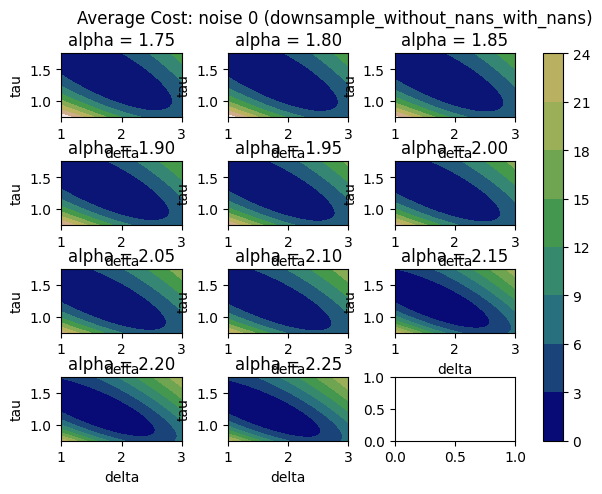

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              30.848255          
3                                              29.970451          
5                                              29.091724          
7                                              28.213008          
9                                              27.335241          
...                                                  ...          
18933                                          18.346615          
18935                                          19.013190          
18937                                          19.668481          
18939                                          20.311842          
18941                                          20.942715          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1.75, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   1.75  1.25    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1.75, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.215212e-03   1.70  1.20   2.15
1      0         0  3.713006e-28   1.75  1.25   2.00
2      0         0  5.315886e-03   1.80  1.30   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.998087963201849; at
      delta   tau  alpha
7160   1.75  1.25    2.0


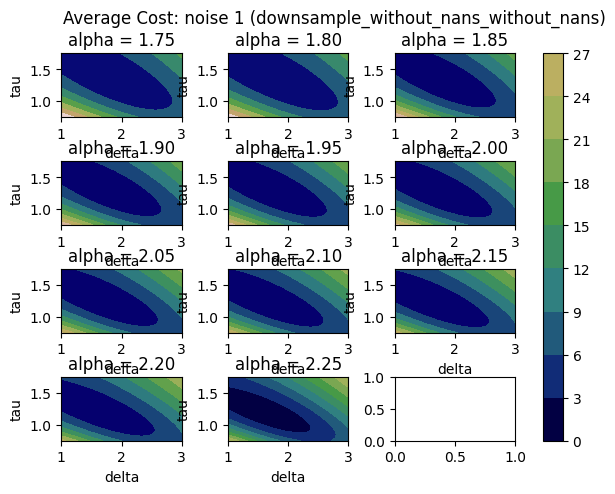

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.058988813649108; at
      delta   tau  alpha
7160   1.75  1.25    2.0


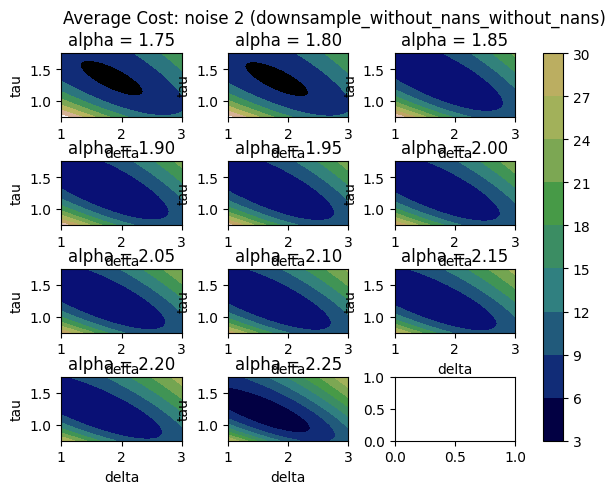

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.99117742694623; at
      delta   tau  alpha
7160   1.75  1.25    2.0


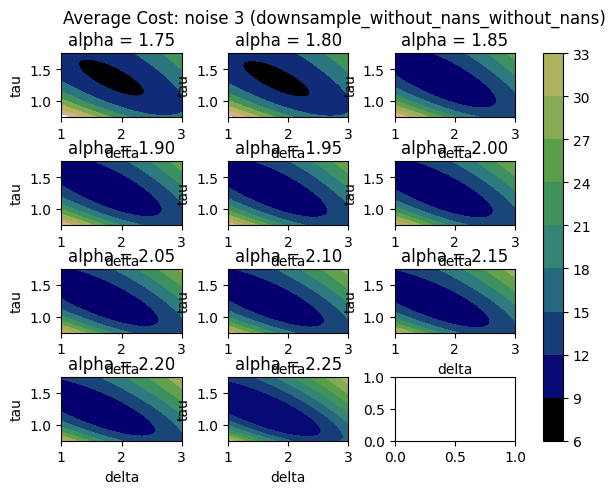

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.939024424667178; at
      delta  tau  alpha
6222   1.65  1.2    2.2


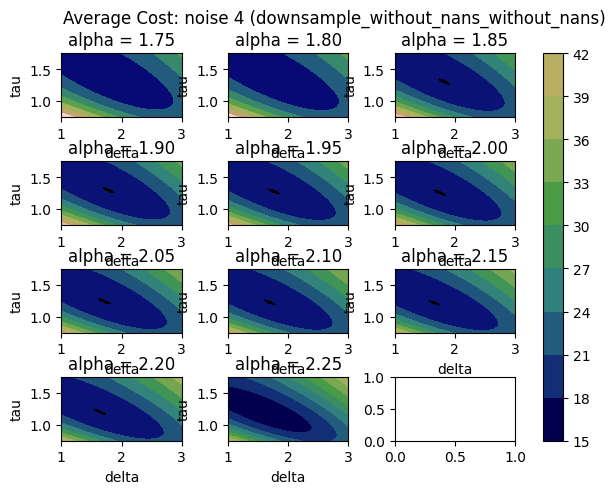

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.090295687277393; at
      delta   tau  alpha
7160   1.75  1.25    2.0


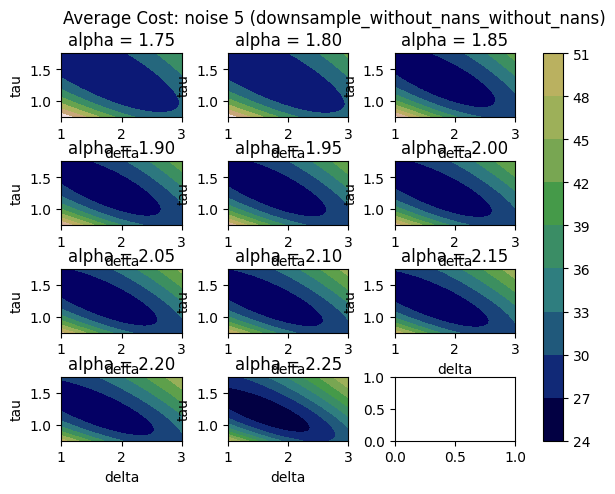

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 35.91314525602558; at
      delta   tau  alpha
7160   1.75  1.25    2.0


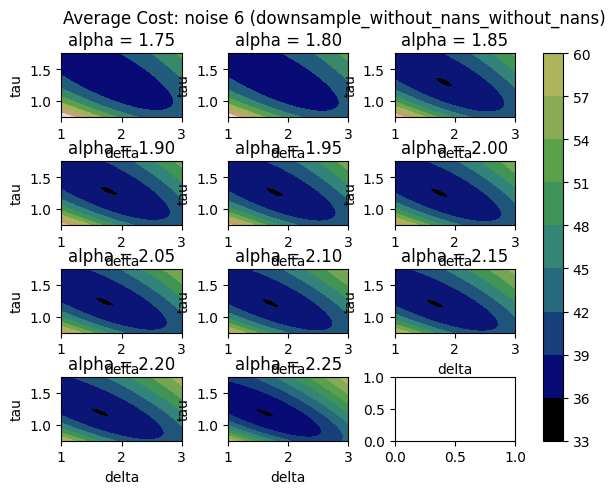

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.46828515644388; at
      delta   tau  alpha
7160   1.75  1.25    2.0


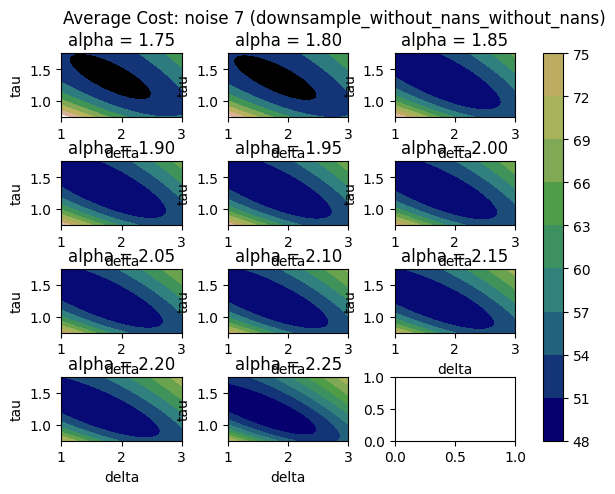

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.0908352414505; at
      delta   tau  alpha
7160   1.75  1.25    2.0


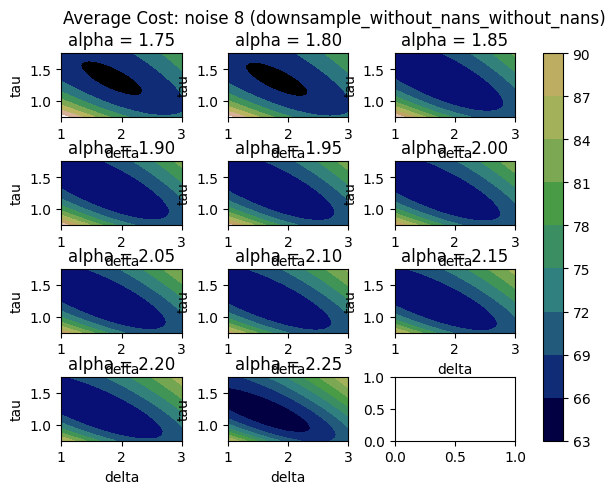

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.41873628195472; at
      delta   tau  alpha
7160   1.75  1.25    2.0


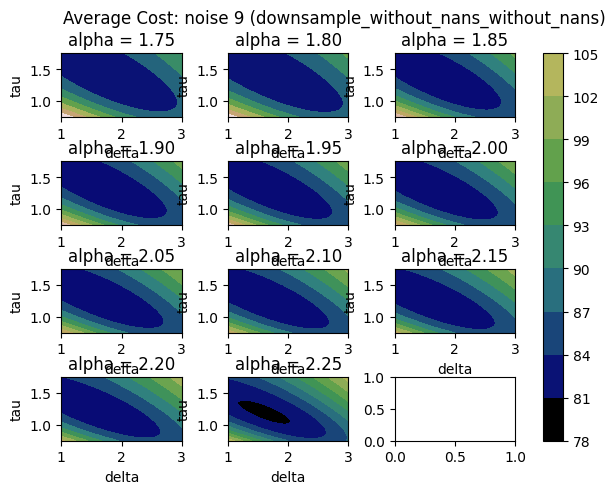

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.09020852270551; at
      delta   tau  alpha
8118   1.85  1.35   1.75


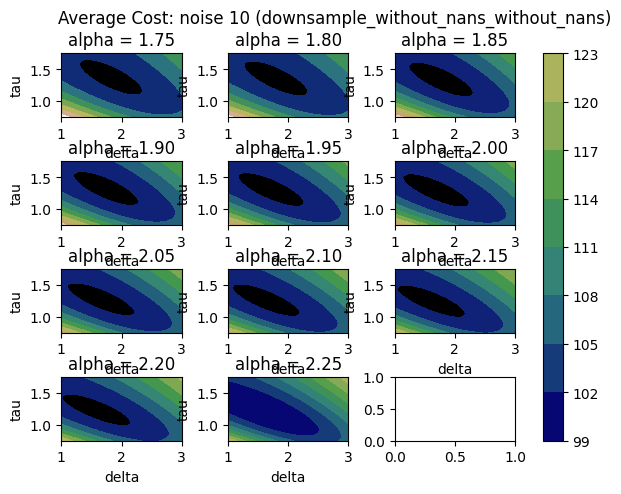

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

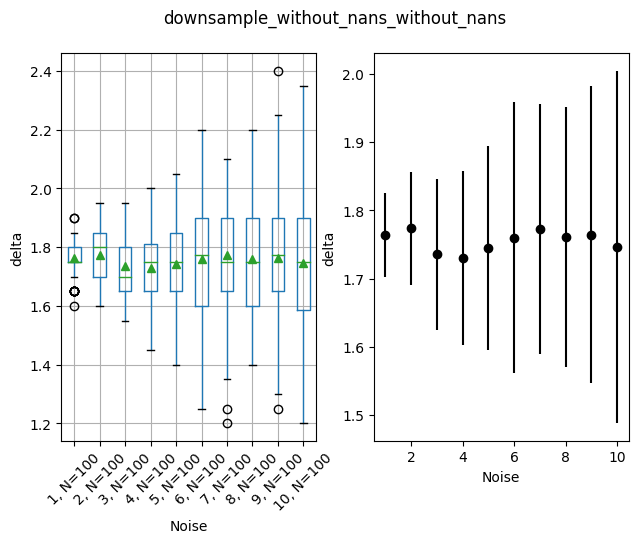

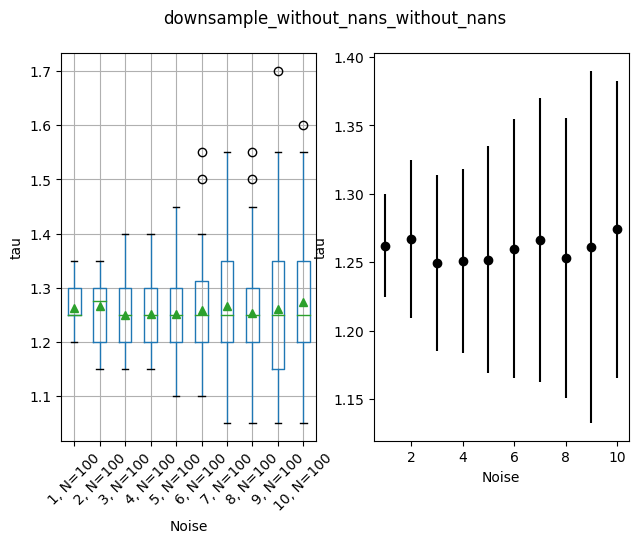

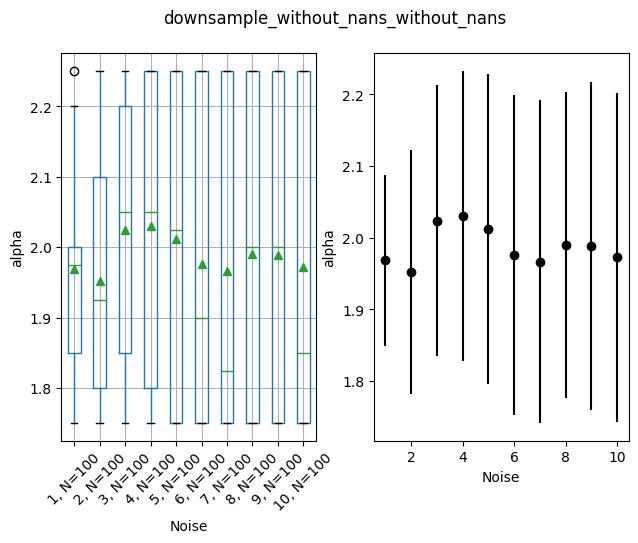

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9951697119375906; at
      delta   tau  alpha
7161   1.75  1.25    2.0


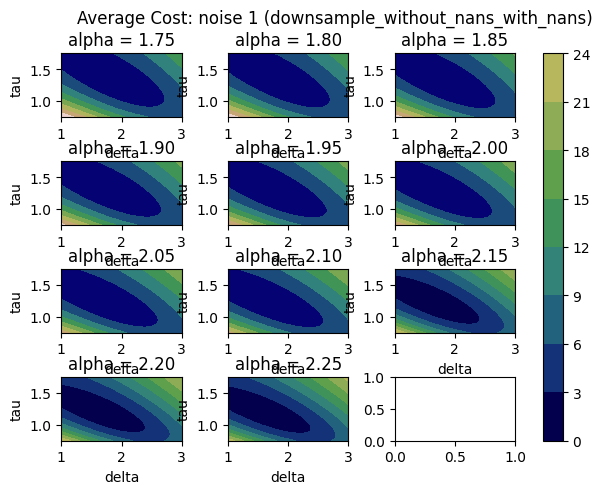

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.068199959052217; at
      delta   tau  alpha
7161   1.75  1.25    2.0


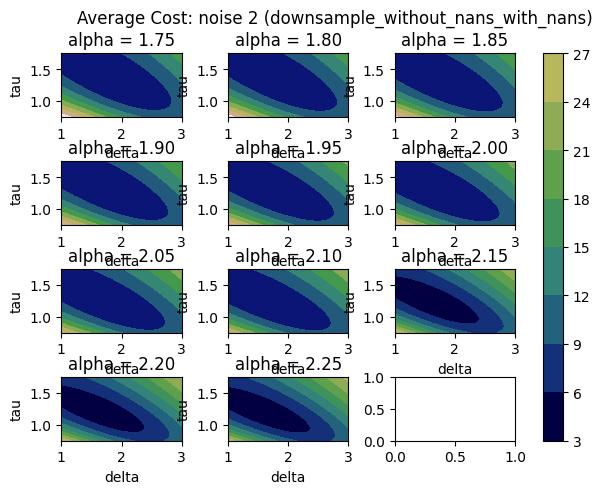

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.994394706703027; at
      delta   tau  alpha
7161   1.75  1.25    2.0


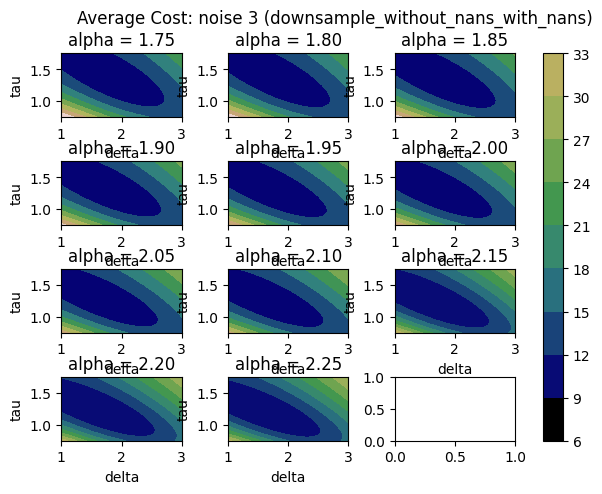

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.901521765805501; at
      delta  tau  alpha
6223   1.65  1.2    2.2


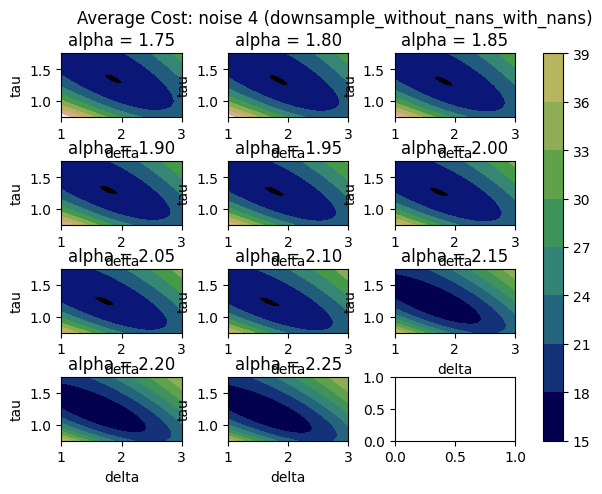

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.29883387709106; at
      delta   tau  alpha
7161   1.75  1.25    2.0


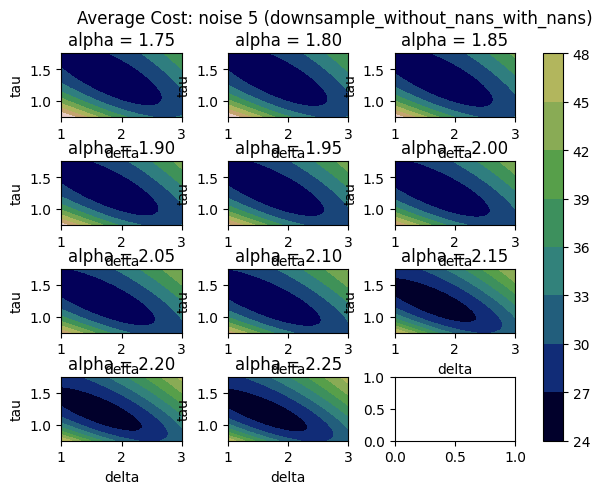

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.914136061572556; at
      delta   tau  alpha
7161   1.75  1.25    2.0


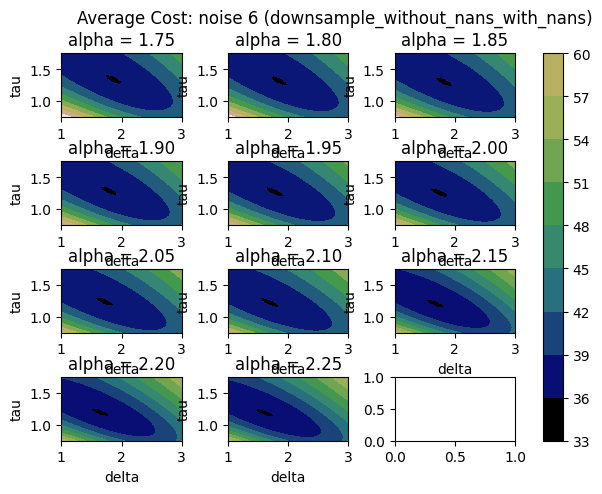

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.37768471563065; at
      delta  tau  alpha
6683    1.7  1.2   2.15


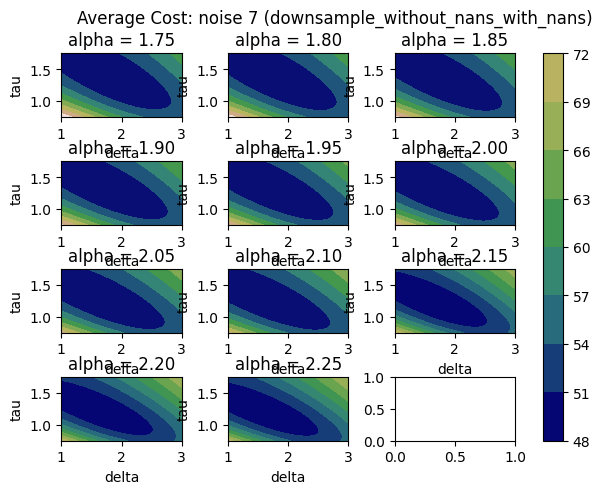

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.18754247353984; at
      delta   tau  alpha
7161   1.75  1.25    2.0


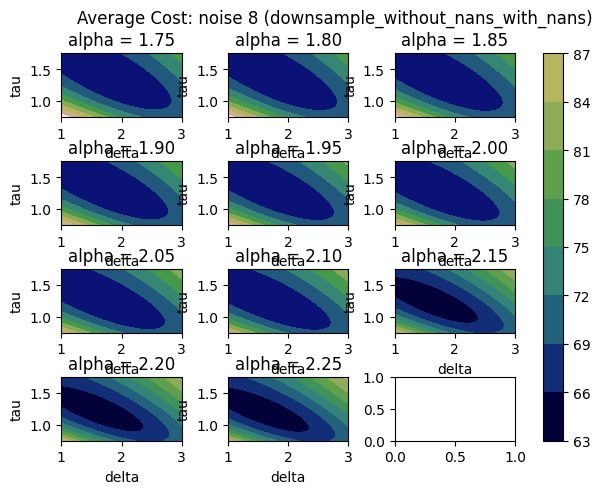

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.71279553654634; at
      delta   tau  alpha
7161   1.75  1.25    2.0


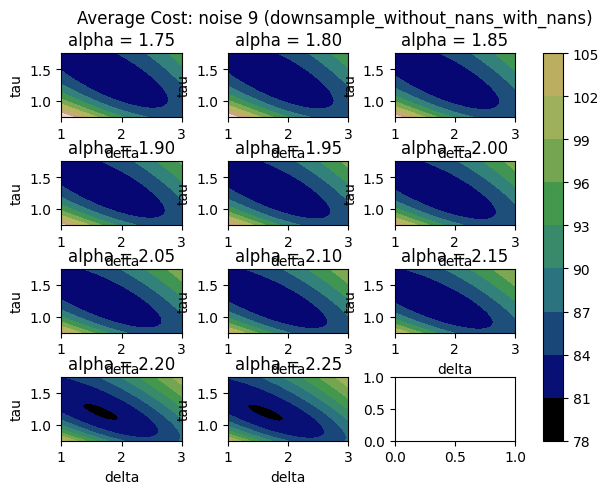

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 98.87868384789601; at
      delta   tau  alpha
6701    1.7  1.25   2.05


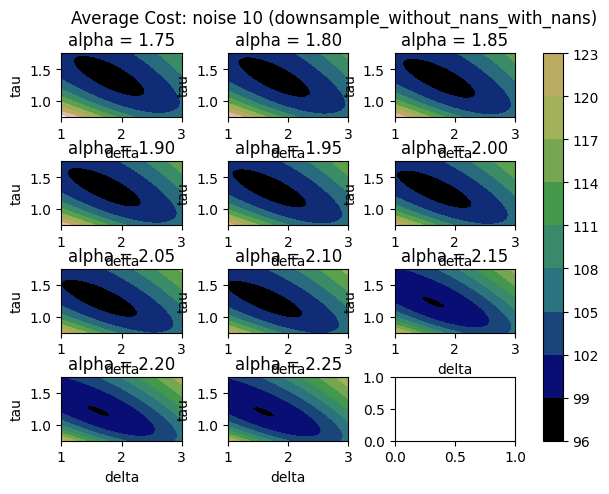

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


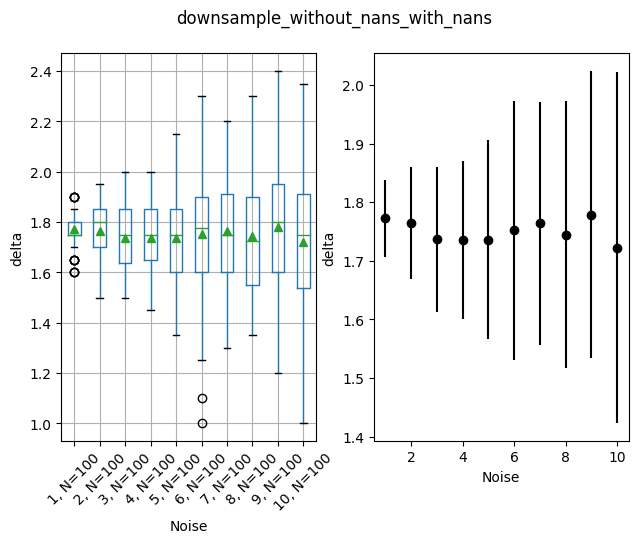

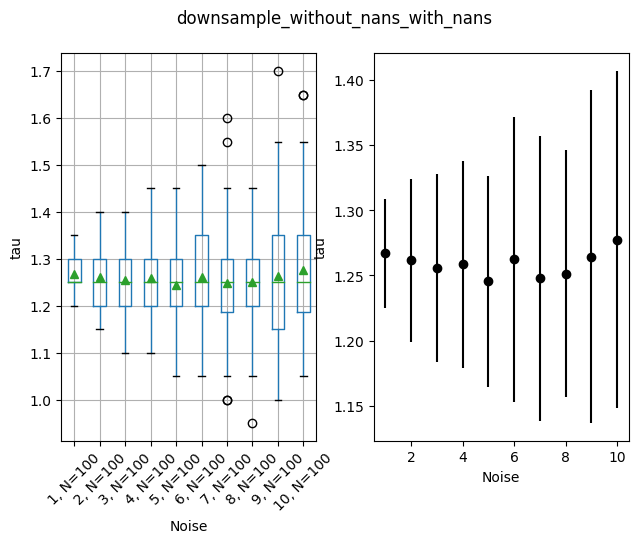

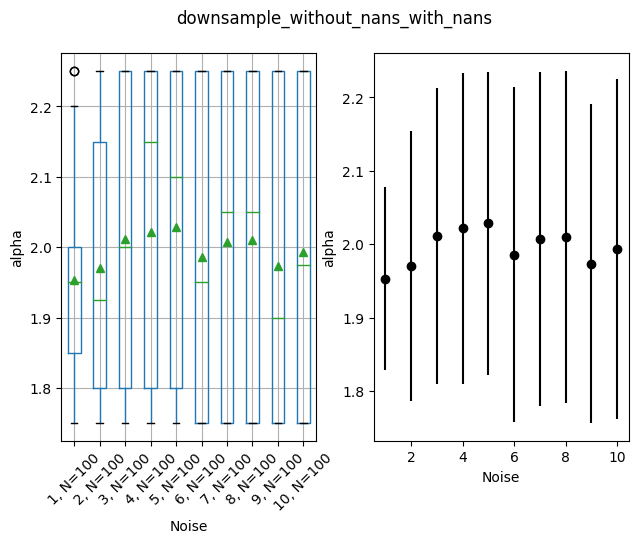

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        14    1.032712  1.6000000000000005  1.2000000000000004   
1         1        38    0.961695  1.6000000000000005  1.2000000000000004   
2         1        39    1.002108  1.6000000000000005  1.2000000000000004   
3         1        79    1.054816  1.6000000000000005  1.2000000000000004   
4         1        80    1.077084  1.6000000000000005  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2701     10        82   97.708502   2.200000000000001  1.2000000000000004   
2702     10        15  103.060712   2.200000000000001  1.2500000000000004   
2703     10        82   97.700563   2.250000000000001  1.2500000000000004   
2704     10        92  101.003225   2.250000000000001  1.2500000000000004   
2705     10        87  106.029330  2.3500000000000014  1.2500000000000004   

     alpha  
0      2.2  
1      2.2  
2      2.2  
3      2.2  
4      2.2  
...    ...  
2701  1.85  
2702   1.8  
2703  1.75  
2704  1.75  
2705  1.75  

[2706 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.40  0.512471  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.44  0.671498  1.0  3.0  4.0  4.0  4.0
3                      100.0  3.06  0.930081  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.80  0.994937  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.80  1.034750  1.0  2.0  3.0  4.0  4.0
6                      100.0  2.49  1.105496  1.0  1.0  3.0  3.0  4.0
7                      100.0  2.30  1.150318  1.0  1.0  2.0  3.0  5.0
8                      100.0  2.44  1.148737  1.0  1.0  3.0  3.0  4.0
9                      100.0  2.26  1.160111  1.0  1.0  2.0  3.0  4.0
10                     100.0  2.07  1.130433  1.0  1.0  2.0  3.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration      cost delta                 tau               alpha
2273      9        72  79.87792   1.0  1.6500000000000008  2.0500000000000003

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration       cost               delta                 tau alpha
2278      9        72  79.845296  1.3000000000000003  1.7500000000000009  1.75

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
256       1        14    1.031133  1.8000000000000007  1.3500000000000005   
257       1        38    0.946238  1.8000000000000007  1.3500000000000005   
258       1        39    1.007004  1.8000000000000007  1.3500000000000005   
303       1         0    0.954407  1.8500000000000008  1.3500000000000005   
304       1         3    0.983269  1.8500000000000008  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2699     10        26  106.239134   2.200000000000001  1.2000000000000004   
2700     10        54   96.037481   2.200000000000001  1.2000000000000004   
2703     10        82   97.700563   2.250000000000001  1.2500000000000004   
2704     10        92  101.003225   2.250000000000001  1.2500000000000004   
2705     10        87  106.029330  2.3500000000000014  1.2500000000000004   

     alpha  
256   1.75  
257   1.75  
258   1.75  
303   1.75  
304   1.75  
...    ...  
2699  1.75  
2700  1.75  
2703  1.75  
2704  1.75  
2705  1.75  

[406 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        34      3  1.8500000000000008   30    34      1  1.3500000000000005   
10       47     17  1.8500000000000008    7    47      9  1.3500000000000005   
2        39      4  1.8500000000000008   20    39      2  1.3500000000000005   
3        29      5  1.8000000000000007    8    29      3  1.3500000000000005   
4        36      7  1.8500000000000008   13    36      4  1.3000000000000005   
5        40     11  1.9000000000000008   11    40      6  1.3500000000000005   
6        49     13  1.8500000000000008   11    49      8  1.3000000000000005   
7        45     12  1.9000000000000008    8    45      8  1.3000000000000005   
8        38     13  1.7000000000000006    6    38      9  1.3500000000000005   
9        49     17  1.8500000000000008    7    49     12  1.3500000000000005   

            
      freq  
noise       
1       34  
10      11  
2       28  
3       16  
4       16  
5       13  
6       18  
7       11  
8        8  
9       13

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
5         1         7    0.913795  1.6000000000000005  1.2000000000000004   
6         1        12    0.949462  1.6000000000000005  1.2000000000000004   
7         1        18    0.990464  1.6000000000000005  1.2000000000000004   
8         1        22    1.048203  1.6000000000000005  1.2000000000000004   
9         1        31    0.980089  1.6000000000000005  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2643     10        86   93.472196  1.9000000000000008  1.1500000000000004   
2665     10        93  106.559850   2.000000000000001  1.0500000000000003   
2666     10        15  103.049535   2.000000000000001  1.1000000000000003   
2678     10        26  106.261985  2.0500000000000007  1.0500000000000003   
2681     10        82   97.723741  2.0500000000000007  1.1000000000000003   

                   alpha  
5     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
8     2.2500000000000004  
9     2.2500000000000004  
...                  ...  
2643  2.2500000000000004  
2665  2.2500000000000004  
2666  2.2500000000000004  
2678  2.2500000000000004  
2681  2.2500000000000004  

[425 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        14      3  1.6000000000000005    9    14      2  1.2000000000000004   
10       45     17  1.5000000000000004    7    45      7  1.2500000000000004   
2        39      5  1.7000000000000006   14    39      2  1.1500000000000004   
3        48      6  1.6500000000000006   14    48      3  1.2000000000000004   
4        45      9  1.6500000000000006   13    45      4  1.2000000000000004   
5        51      9  1.6500000000000006   13    51      5  1.1500000000000004   
6        36     12  1.5500000000000005    7    36      5  1.1500000000000004   
7        43     15  1.6500000000000006   10    43      7  1.2000000000000004   
8        50     12  1.5500000000000005   11    50      7  1.1500000000000004   
9        54     16  1.7000000000000006    9    54      8  1.1500000000000004   

            
      freq  
noise       
1        9  
10      10  
2       23  
3       23  
4       21  
5       26  
6       12  
7       14  
8       19  
9       14

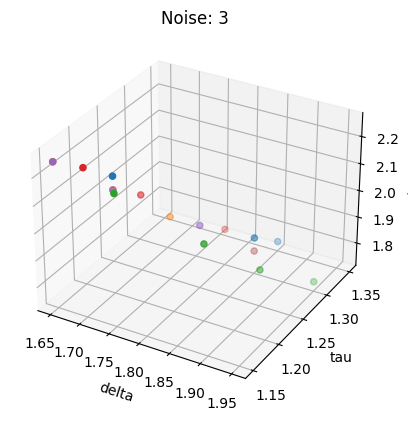

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

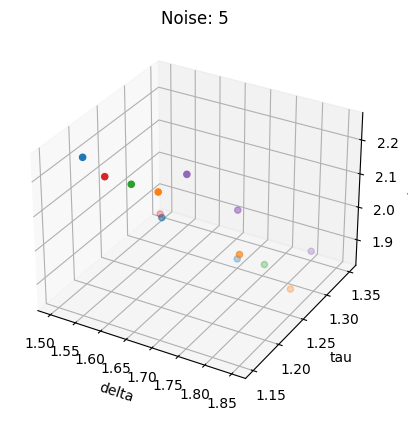

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

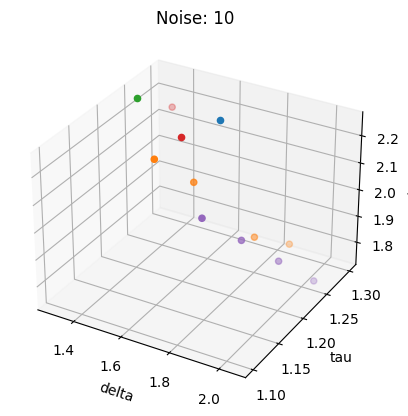

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        38    0.965299  1.5500000000000005  1.2000000000000004   
1         1         0    0.917579  1.6000000000000005  1.2000000000000004   
2         1        14    0.995140  1.6000000000000005  1.2000000000000004   
3         1        22    1.034542  1.6000000000000005  1.2000000000000004   
4         1        39    1.028071  1.6000000000000005  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2518     10        54   94.031088   2.250000000000001  1.2000000000000004   
2519     10        86   97.444498   2.250000000000001  1.2500000000000004   
2520     10         7   98.782102   2.300000000000001  1.1500000000000004   
2521     10        92   98.577271  2.3500000000000014  1.1500000000000004   
2522     10        87  112.601342  2.3500000000000014  1.3000000000000005   

                   alpha  
0     2.2500000000000004  
1                    2.2  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2518                1.75  
2519                1.75  
2520                1.75  
2521                1.75  
2522                1.75  

[2523 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.41  0.514340  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.23  0.776615  1.0  3.0  3.0  4.0  4.0
3                      100.0  2.98  0.931817  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.75  1.018763  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.70  1.000000  1.0  2.0  3.0  3.0  4.0
6                      100.0  2.15  1.076611  1.0  1.0  2.0  3.0  4.0
7                      100.0  1.97  1.095952  1.0  1.0  2.0  3.0  5.0
8                      100.0  2.22  1.106272  1.0  1.0  2.0  3.0  4.0
9                      100.0  1.96  1.091010  1.0  1.0  2.0  3.0  5.0
10                     100.0  1.86  1.015237  1.0  1.0  1.5  3.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration       cost delta                 tau               alpha
1507      6        88  39.367863   1.0  1.3500000000000005  2.2500000000000004
2337     10        13  90.877800   1.0  1.3500000000000005  2.2500000000000004
2338     10        89  93.117912   1.0  1.4000000000000006  2.2500000000000004

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
263       1         0    0.923785  1.8000000000000007  1.3500000000000005   
264       1        14    0.984980  1.8000000000000007  1.3500000000000005   
265       1        70    1.177620  1.8000000000000007  1.3500000000000005   
303       1         2    0.921145  1.8500000000000008  1.3500000000000005   
304       1         3    0.976231  1.8500000000000008  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2518     10        54   94.031088   2.250000000000001  1.2000000000000004   
2519     10        86   97.444498   2.250000000000001  1.2500000000000004   
2520     10         7   98.782102   2.300000000000001  1.1500000000000004   
2521     10        92   98.577271  2.3500000000000014  1.1500000000000004   
2522     10        87  112.601342  2.3500000000000014  1.3000000000000005   

     alpha  
263   1.75  
264   1.75  
265   1.75  
303   1.75  
304   1.75  
...    ...  
2518  1.75  
2519  1.75  
2520  1.75  
2521  1.75  
2522  1.75  

[376 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        33      4  1.8500000000000008   28    33      2  1.3500000000000005   
10       45     18   2.000000000000001    6    45     11  1.3500000000000005   
2        40      4  1.8500000000000008   19    40      3  1.3500000000000005   
3        32      6  1.9000000000000008    9    32      4  1.3500000000000005   
4        31      8  1.8500000000000008    7    31      5  1.3000000000000005   
5        31     12  1.9500000000000008    5    31      7  1.3500000000000005   
6        43     14  1.8500000000000008    7    43      8  1.4000000000000006   
7        43     12  1.9000000000000008    7    43      9  1.4000000000000006   
8        38     15   2.000000000000001    7    38      9  1.3000000000000005   
9        40     16  1.9500000000000008    6    40     10  1.4000000000000006   

            
      freq  
noise       
1       32  
10       9  
2       26  
3       16  
4       10  
5       11  
6       12  
7        9  
8        7  
9        9

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        38    0.965299  1.5500000000000005  1.2000000000000004   
6         1        12    0.913979  1.6000000000000005  1.2000000000000004   
7         1        75    1.003681  1.6000000000000005  1.2000000000000004   
8         1        87    0.994885  1.6000000000000005  1.2000000000000004   
9         1        92    1.050115  1.6000000000000005  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2485     10        20   90.210697   2.000000000000001  1.0500000000000003   
2486     10        60   93.733737   2.000000000000001  1.0500000000000003   
2498     10        26  104.031937  2.0500000000000007  1.0500000000000003   
2503     10        25  105.122980   2.100000000000001  1.0000000000000002   
2504     10        93  104.501868   2.100000000000001  1.1000000000000003   

                   alpha  
0     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
8     2.2500000000000004  
9     2.2500000000000004  
...                  ...  
2485  2.2500000000000004  
2486  2.2500000000000004  
2498  2.2500000000000004  
2503  2.2500000000000004  
2504  2.2500000000000004  

[420 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        14      4  1.6500000000000006    5    14      2  1.1500000000000004   
10       44     17  1.5500000000000005    5    44     10  1.2500000000000004   
2        37      6  1.7000000000000006   13    37      3  1.1500000000000004   
3        44      8  1.6000000000000005   11    44      4  1.2000000000000004   
4        47      9  1.6000000000000005   10    47      5  1.2000000000000004   
5        48     12  1.7000000000000006    7    48      6  1.1500000000000004   
6        44     15  1.6000000000000005    7    44      8  1.2000000000000004   
7        46     16  1.5000000000000004    7    46      8  1.2000000000000004   
8        48     16  1.7000000000000006    8    48      8  1.2000000000000004   
9        48     18  1.5000000000000004    5    48      8  1.1500000000000004   

            
      freq  
noise       
1        8  
10      10  
2       23  
3       20  
4       21  
5       19  
6       14  
7       18  
8       15  
9        9

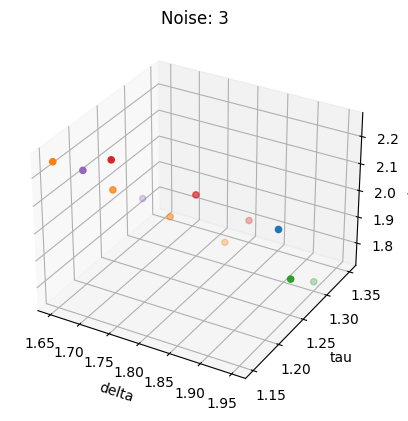

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

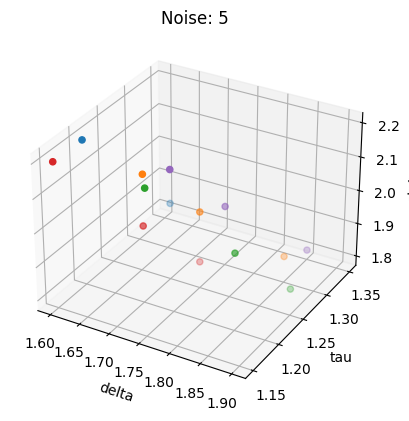

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

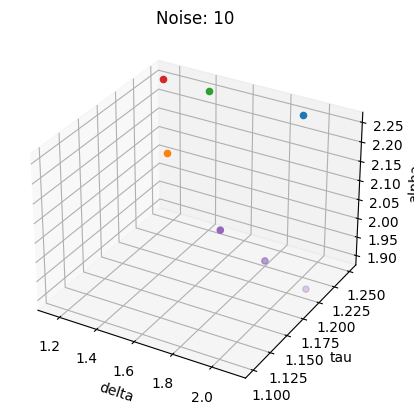

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()